In [1]:
### Author: Andrea Mastropietro © All rights reserved ###

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import SAGEConv

import numpy as np
import random
from sklearn.metrics import confusion_matrix

import networkx as nx
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import GDADataset

### Set Random Seeds

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
# torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working on device: ", device)

Working on device:  cuda


### Data Preparation

We will load graph data representing a PPI network (from BioGRID), containing features for each node/gene, generated for a specific disease. We consider malignant neoplasm of breast as a case study (many known associated genes given the quantity of research on the topic). When then associated the label (associated/not assocaited) to each gene using information gathered from DisGeNET, an online platform storing gene-disease related information.

In [4]:
G = nx.read_gml("data/gene_disease_association_data/graph_C0006142.gml")
seed_genes = pd.read_csv("data/gene_disease_association_data/C0006142_seed_genes.txt", header=None, sep=' ')

seed_genes.columns  = ["name", "GDA Score"]
display(seed_genes.head())

,name,GDA Score
0,NAT2,0.40
1,ABCA3,0.30
2,ABCA4,0.33
3,ABL1,0.40
4,ACADM,0.31


In [5]:
seeds_list = seed_genes["name"].values.tolist()

In [6]:
for node in G:
    print(node, G.nodes[node])

MAP2K4 {'degree': 52, 'ring': 1, 'NetRank': 0.3776224, 'NetShort': 6621.135, 'HeatDiff': 0.7857457, 'InfoDiff': 0.8043124}
FLNC {'degree': 149, 'ring': 2, 'NetRank': 1.904549, 'NetShort': 6874.44, 'HeatDiff': 0.05550523, 'InfoDiff': 0.05931604}
MYPN {'degree': 27, 'ring': 3, 'NetRank': 2.932246, 'NetShort': 255.5409, 'HeatDiff': 0.0007826568, 'InfoDiff': 0.004238711}
ACTN2 {'degree': 129, 'ring': 2, 'NetRank': 1.932025, 'NetShort': 5092.236, 'HeatDiff': 0.03894884, 'InfoDiff': 0.04814739}
ACVR1 {'degree': 58, 'ring': 1, 'NetRank': 0.4443574, 'NetShort': 6898.941, 'HeatDiff': 0.7215197, 'InfoDiff': 0.7137646}
FNTA {'degree': 73, 'ring': 2, 'NetRank': 1.893177, 'NetShort': 6849.385, 'HeatDiff': 0.02677262, 'InfoDiff': 0.04000238}
GATA2 {'degree': 60, 'ring': 2, 'NetRank': 1.896108, 'NetShort': 7060.474, 'HeatDiff': 0.004525843, 'InfoDiff': 0.02046503}
PML {'degree': 311, 'ring': 2, 'NetRank': 1.872093, 'NetShort': 7307.018, 'HeatDiff': 0.08472546, 'InfoDiff': 0.1096246}
RPA2 {'degree': 5

In [7]:
labels = []

for node in G:
    if node in seeds_list:
        labels.append(0)
    else:
        labels.append(1)


In [8]:
features_names = ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']
dataset = GDADataset(G, labels, features_names, num_classes=2)[0] #we have a single graph

In [9]:
dataset

Data(edge_index=[2, 1357864], x=[19761, 6], y=[19761], num_classes=2, train_mask=[19761], test_mask=[19761], val_mask=[19761])

### Define and Train a GNN model

In [10]:
class GraphSAGE(nn.Module):
    def __init__(self, data, hidden_channels=16):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, hidden_channels, aggr='max')
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr='max')
        self.conv3 = SAGEConv(hidden_channels, hidden_channels, aggr='max')
        self.conv4 = SAGEConv(hidden_channels, hidden_channels, aggr='max')
        self.conv5 = SAGEConv(hidden_channels, hidden_channels, aggr='max')
        self.conv6 = SAGEConv(hidden_channels, hidden_channels, aggr='max')
        self.conv7 = SAGEConv(hidden_channels, int(data.num_classes), aggr='max')
    
    def forward(self, x, edge_index):

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv7(x, edge_index)

        return F.log_softmax(x, dim=1)

In [11]:
model = GraphSAGE(dataset, hidden_channels=16)
data = dataset.to(device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
EPOCHS = 10000

train_mask  = data['train_mask']
val_mask    = data['val_mask']
test_mask   = data['test_mask']

In [12]:
# list to plot the train accuracy
train_acc_curve = []
train_lss_curve = []

best_train_acc  = 0
best_val_acc    = 0
best_train_lss  = 999
best_loss_epoch = 0
best_val_loss   = 999

  0%|          | 0/10000 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 0.0632, train acc: 0.9711, val loss: 0.0545, val acc: 0.9845  (best train acc: 0.9743, best val acc: 0.9852, best val loss: 0.0539  @ epoch 2044 )
[Epoch: 0020] train loss: 0.0609, train acc: 0.9727, val loss: 0.0557, val acc: 0.9821  (best train acc: 0.9759, best val acc: 0.9868, best val loss: 0.0528  @ epoch 19 )
[Epoch: 0040] train loss: 0.0569, train acc: 0.9760, val loss: 0.0547, val acc: 0.9835  (best train acc: 0.9766, best val acc: 0.9868, best val loss: 0.0528  @ epoch 19 )
[Epoch: 0060] train loss: 0.0546, train acc: 0.9761, val loss: 0.0536, val acc: 0.9852  (best train acc: 0.9769, best val acc: 0.9868, best val loss: 0.0520  @ epoch 58 )
[Epoch: 0080] train loss: 0.0549, train acc: 0.9764, val loss: 0.0550, val acc: 0.9835  (best train acc: 0.9775, best val acc: 0.9858, best val loss: 0.0517  @ epoch 72 )
[Epoch: 0100] train loss: 0.0536, train acc: 0.9768, val loss: 0.0524, val acc: 0.9852  (best train acc: 0.9783, best val acc: 0.9868, best val

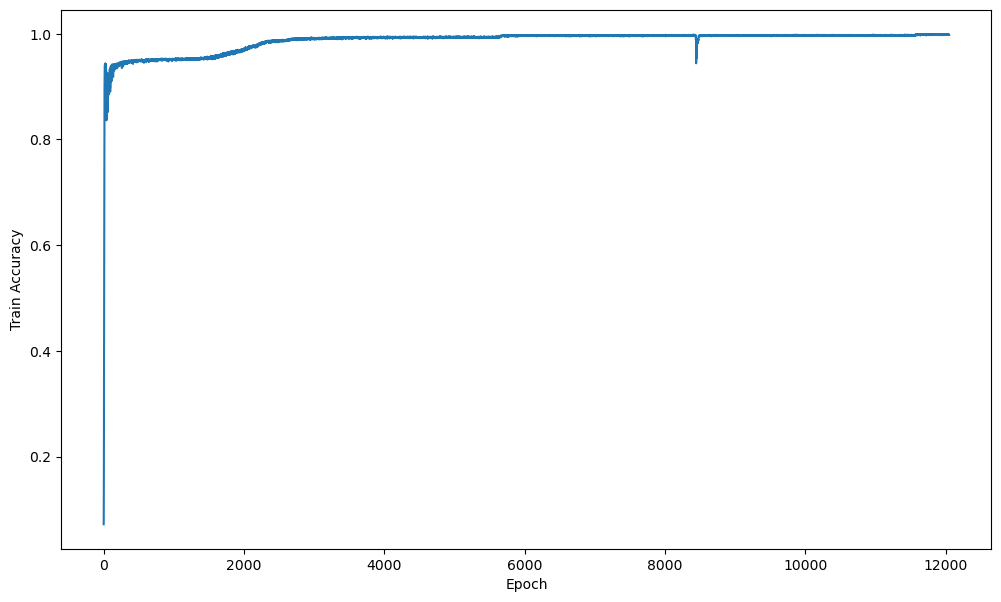

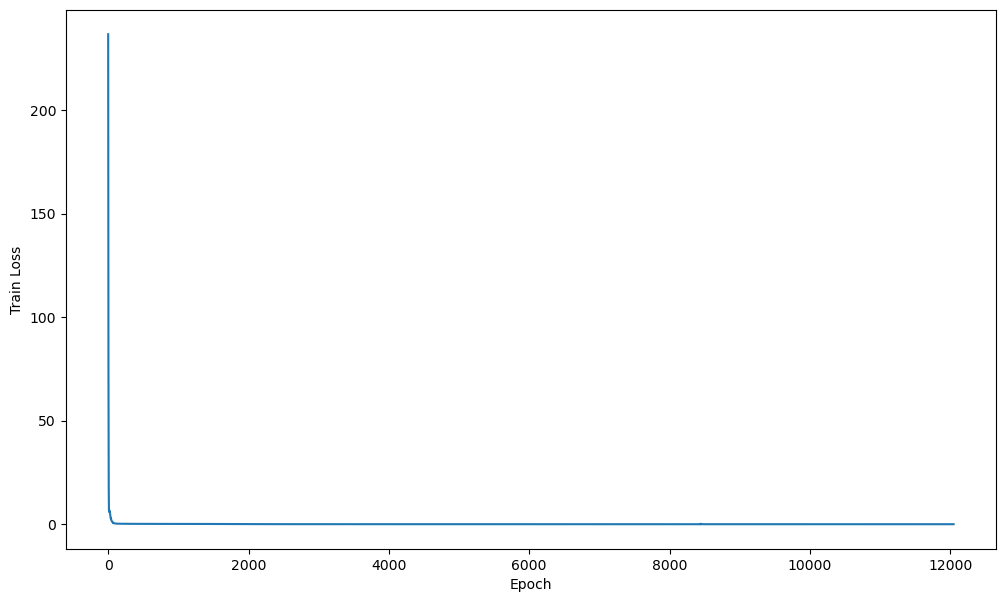

In [14]:
for e in tqdm(range(EPOCHS)):
        model.train()
        optimizer.zero_grad()
        preds      = model(data.x, data.edge_index)
        output      = preds.argmax(1)
         
        train_loss  = F.nll_loss(preds[train_mask], data.y[train_mask])
        train_acc   = (output[train_mask] == data.y[train_mask]).float().mean()
        train_loss.backward()
        optimizer.step()

        # Append train acc. to plot curve later
        train_acc_curve.append(train_acc.item())
        train_lss_curve.append(train_loss.item())

        if train_acc > best_train_acc:
            best_train_acc = train_acc

        # Evaluation and test
        model.eval()
        preds      = model(data.x, data.edge_index)
        output      = preds.argmax(1)
        val_loss    = F.nll_loss(preds[val_mask], data.y[val_mask])
        val_acc     = (output[val_mask] == data.y[val_mask]).float().mean()

        # Update best test/val acc.

        if train_loss < best_train_lss:
            best_train_lss = train_loss

        # Save model with best val loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_loss_epoch = e
            best_val_acc = val_acc
            torch.save(model.state_dict(), "models/graphsage_gnn_model.ckpt")

        if e % 20 == 0 or e == EPOCHS:
            print('[Epoch: {:04d}]'.format(e),
            'train loss: {:.4f},'.format(train_loss.item()),
            'train acc: {:.4f},'.format(train_acc.item()),
            'val loss: {:.4f},'.format(val_loss.item()),
            'val acc: {:.4f} '.format(val_acc.item()),
            '(best train acc: {:.4f},'.format(best_train_acc.item()),
            'best val acc: {:.4f},'.format(best_val_acc),
            'best val loss: {:.4f} '.format(best_val_loss),
            '@ epoch', best_loss_epoch ,')')
    
# Plot training accuracy curve
plt.figure(figsize = (12,7))
plt.plot(train_acc_curve)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.show()

plt.figure(figsize = (12,7))
plt.plot(train_lss_curve)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()


### Load and Test GNN Model

In [15]:
loaded_model = GraphSAGE(data, hidden_channels=16)
    
loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(torch.load("models/graphsage_gnn_model.ckpt", map_location=torch.device(device)))
loaded_model.eval()
preds = loaded_model(data.x, data.edge_index)
output = preds.argmax(1)

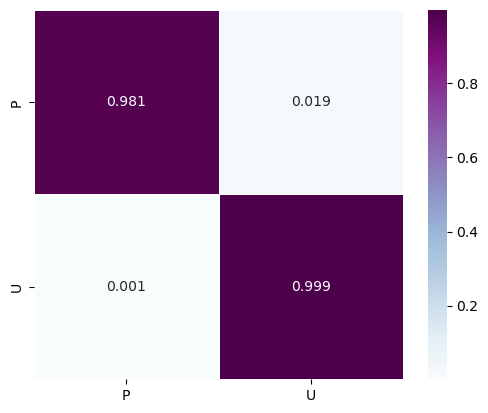

In [16]:
cm = confusion_matrix(data.y[test_mask].to('cpu'), output[test_mask].to('cpu'), normalize="true")
classes = ['P', 'U']
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
plt.show()
